In [1]:
import sys
from pathlib import Path

# Add the root project folder to the python path in order to use the packages
path_root = Path( '/project_ghent/HADSP/hadsp/')
sys.path.append(str(path_root))

In [2]:
import numpy as np
from scipy import sparse
from tqdm import tqdm
from importlib import reload

# SEED
SEED = 49387

from matplotlib import pyplot as plt
from seaborn import heatmap, color_palette

# Datasets

Lots of different on availabale : https://towardsdatascience.com/a-data-lakes-worth-of-audio-datasets-b45b88cd4ad

Classification: 
https://arxiv.org/abs/1803.07870

https://github.com/FilippoMB/Time-series-classification-and-clustering-with-Reservoir-Computing

Multivariate:
https://www.timeseriesclassification.com/dataset.php

## Torchaudio

https://pytorch.org/audio/stable/datasets.html


## Prediction ahead

Datasets available :

* MackeyGlass
* Lorenz

from datasets.load_datasets import load_dataset_prediction
is_instances_classification = False
dataset_name = "MackeyGlass"
step_ahead=5

is_multivariate, sampling_rate, X_train, X_val, X_test, Y_train, Y_val, Y_test, X_pretrain = load_dataset_prediction(dataset_name, step_ahead, visualize=True)


## Classification

Datasets available :

* FSDD
* HAART
* JapaneseVowels

In [3]:
from datasets.load_datasets import load_dataset_classification
is_instances_classification = True
dataset_name = "JapaneseVowels"

is_multivariate, sampling_rate, X_train, X_val, X_test, Y_train, Y_val, Y_test, X_pretrain = load_dataset_classification(dataset_name)

## Multivariate generation if necessary

Spectrograms_vs_Cochleagrams : https://www.researchgate.net/publication/340510607_Speech_recognition_using_very_deep_neural_networks_Spectrograms_vs_Cochleagrams

Attention ! For multivariate shape should be : (nb_of_timeseries, nb_of_timesteps)

In [4]:
if is_multivariate:
    X_train_band, X_val_band, X_test_band, X_pretrain_band = X_train, X_val, X_test, X_pretrain
    del X_train
    del X_val
    del X_test
    del X_pretrain

Frequency limit:  5000.0 (Shannon sampling theorem)


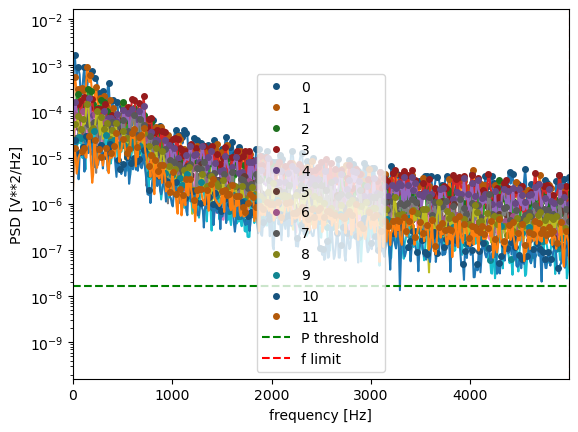

Number of frequencies selected : 12


/Users/tanguy/Code/Finebouche/hadsp/datasets/multivariate_generation.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(filtered_peak_freqs)


In [5]:
from datasets.multivariate_generation import extract_peak_frequencies

if is_instances_classification:
    pretrain_data = np.concatenate(X_pretrain_band, axis=0)
elif is_multivariate:
    pretrain_data = X_pretrain_band.T
else:
    pretrain_data = X_pretrain

filtered_peak_freqs = extract_peak_frequencies(pretrain_data, sampling_rate, threshold=1e-5, nperseg=1024, visualize=True)

#print("Filtered peak frequencies: ", filtered_peak_freqs)
print("Number of frequencies selected :", len(filtered_peak_freqs))

### Applying normal band pass filter on data and standardisation (inside the function)

In [6]:
from datasets.multivariate_generation import generate_multivariate_dataset, extract_peak_frequencies

if not is_multivariate:
    X_pretrain_band = generate_multivariate_dataset(
        filtered_peak_freqs, X_pretrain, sampling_rate, is_instances_classification, nb_jobs=-1
    )
    X_train_band = generate_multivariate_dataset(
        filtered_peak_freqs, X_train, sampling_rate, is_instances_classification, nb_jobs=-1
    )
    X_val_band = generate_multivariate_dataset(
        filtered_peak_freqs, X_val, sampling_rate, is_instances_classification, nb_jobs=-1
    )
    X_test_band = generate_multivariate_dataset(
        filtered_peak_freqs, X_test, sampling_rate, is_instances_classification, nb_jobs=-1
    )


### Standardizing the amplitudes

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler_x_uni = MinMaxScaler(feature_range=(0, 1))
scaler_x_multi = MinMaxScaler(feature_range=(0, 1))

if is_instances_classification:
    print("processing for Classification")
    # Transform the training, validation and test data using the same scaler
    scaler_x_multi.fit(np.concatenate(X_train_band, axis=0))

    X_pretrain_band = np.array([scaler_x_multi.transform(time_series) for time_series in tqdm(X_pretrain_band)])
    X_train_band = np.array([scaler_x_multi.transform(time_series) for time_series in tqdm(X_train_band)])
    X_val_band = np.array([scaler_x_multi.transform(time_series) for time_series in tqdm(X_val_band)])
    X_test_band = np.array([scaler_x_multi.transform(time_series) for time_series in tqdm(X_test_band)])

    if not is_multivariate:
        # Transform the training, validation and test data using the same scaler
        X_pretrain = np.array([scaler_x_uni.transform(x).flatten() for x in tqdm(X_pretrain)])
        X_train = np.array([scaler_x_uni.transform(x).flatten() for x in tqdm(X_train)])
        X_val = np.array([scaler_x_uni.transform(x).flatten() for x in tqdm(X_val)])
        X_test = np.array([scaler_x_uni.transform(x).flatten() for x in tqdm(X_test)])
else :
    print("processing for Prediction")
    train_len= X_train_band.shape[0]

    scaler_y = MinMaxScaler(feature_range=(0, 1))
    Y_train = scaler_y.fit_transform(Y_train)
    Y_val = scaler_y.transform(Y_val)
    Y_test = scaler_y.transform(Y_test)

    # FOR MULTIVARIATE DATA
    X_pretrain_band_scale = np.zeros(X_pretrain_band.shape)
    X_train_band_scale = np.zeros(X_pretrain_band.shape)
    X_val_band_scale = np.zeros(X_pretrain_band.shape)
    X_test_band_scale = np.zeros(X_pretrain_band.shape)
    for i in range(X_pretrain_band.shape[1]):
        min = X_pretrain_band[:,i].min()
        max = X_pretrain_band[:,i].max()
        
        X_pretrain_band_scale[:,i] = (X_pretrain_band[:,i]- min) / (max - min)
        X_train_band_scale[:,i] = (X_train_band[:,i] - min) / (max - min)
        X_val_band_scale[:,i] = (X_val_band[:,i]- min) / (max - min)
        X_test_band_scale[:,i] = (X_test_band[:,i]- min) / (max - min)

    if not is_multivariate:
        X_pretrain = scaler_x_uni.fit_transform(X_pretrain)
        X_train = scaler_x_uni.transform(X_train)
        X_val = scaler_x_uni.transform(X_val)
        X_test = scaler_x_uni.transform(X_test)



processing for Classification


100%|██████████████████████████████████████████████████| 216/216 [00:00<00:00, 37287.31it/s]
/var/folders/c9/p_q1xbbj7sv7nwvd_17c75lh0000gn/T/ipykernel_14042/3471420539.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_pretrain_band = np.array([scaler_x_multi.transform(time_series) for time_series in tqdm(X_pretrain_band)])
100%|██████████████████████████████████████████████████| 216/216 [00:00<00:00, 45760.67it/s]
/var/folders/c9/p_q1xbbj7sv7nwvd_17c75lh0000gn/T/ipykernel_14042/3471420539.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_t

In [8]:
if not is_instances_classification:
    X_train_band, X_test_band, X_val_band, X_pretrain_band = X_train_band_scale, X_test_band_scale, X_val_band_scale, X_pretrain_band_scale
    del X_train_band_scale
    del X_val_band_scale
    del X_test_band_scale
    del X_pretrain_band_scale

## Plot pretraining dataset

In [9]:
# Min window size to get all the dynamics ? 
min_window_size = sampling_rate/np.max(np.hstack(filtered_peak_freqs))
max_window_size = sampling_rate/np.min(np.hstack(filtered_peak_freqs))

print(min_window_size)
print(max_window_size)

2.003913894324853
512.0


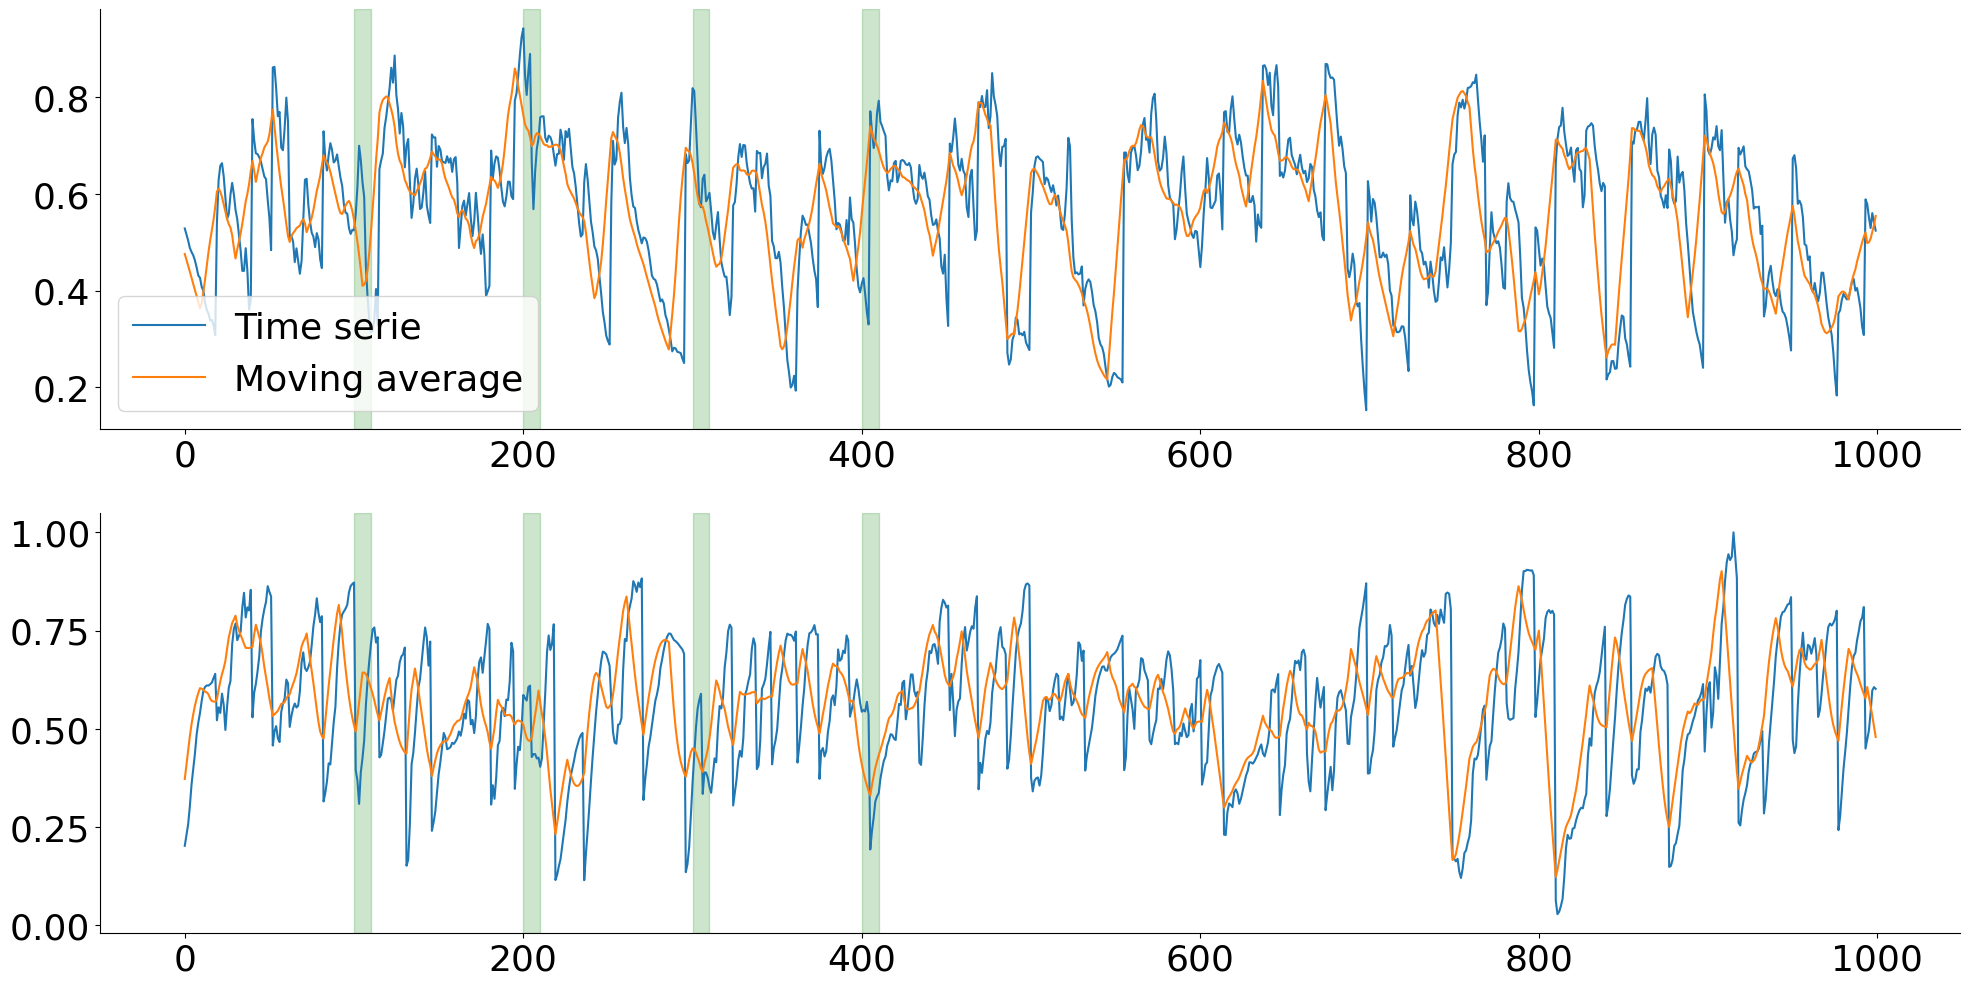

In [10]:
#Compute the moving average 
window_size = 10
if is_instances_classification:
    filtered_data =  np.concatenate(X_pretrain_band, axis=0).T
else:
    filtered_data =  X_pretrain_band.T

if max_window_size <= window_size or  window_size <= min_window_size:
    raise ValueError(f"window_size must be greater than {min_window_size} and smaller than {max_window_size}. Current window_size is {window_size}.")

weights = np.repeat(1.0, window_size)/window_size
ma = np.array([np.convolve(d, weights, 'valid') for d in (filtered_data)])

START = 0
END = 1000
DIFF = END - START
#CPlot the two for different frequencies
NB_1 = 0
fig, ax = plt.subplots(2, 1, figsize=(24,12))
ax[0].plot(range(DIFF), filtered_data[NB_1, START:END], label='Time serie')
ax[0].plot(range(DIFF), ma[NB_1, START:END], label='Moving average')
ax[0].legend(fontsize=26)

NB_2 = 4
ax[1].plot(range(DIFF), filtered_data[NB_2, START:END], label='Time serie')
ax[1].plot(range(DIFF), ma[NB_2, START:END], label='Moving average')

for i, ax in enumerate(ax):
    # Format subplot
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', labelsize=26)
    # draw vertical lines to show the window_size
    for x in range(100, 500, 100):
        ax.axvspan(x, x + window_size, color='g', alpha=0.2)

plt.show()

## Find common dimension

In [11]:
def find_common_dimension(array1, array2):
    matching_indices = None
    matching_values = None

    if array2.shape[0] == array1.shape[0]:
        matching_index = 0
    elif array2.shape[1] == array1.shape[1]:
        matching_index = 1
    else:
        print("error")

    return matching_index

if is_instances_classification: # Multiple instances -> classification
    common_index = find_common_dimension(X_pretrain_band[0], X_pretrain_band[2])
else:
    common_index = 0

common_size = X_pretrain_band[0].shape[common_index]

print("Common dimension index is :", common_index)
print("Number of different time series is :", common_size)
if is_multivariate:
    print("\nCheck it ! \nFirst array ", X_pretrain_band[0].shape, " and second array", X_train_band[2].shape)


Common dimension index is : 1
Number of different time series is : 12

Check it ! 
First array  (19, 12)  and second array (12, 12)


# Generating reservoirs

## Reservoir functions

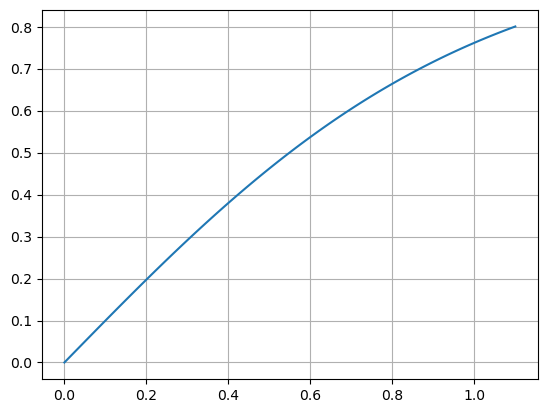

In [12]:
from reservoir.activation_functions import tanh, heaviside, sigmoid

# the activation function choosen for the rest of the experiment
# activation_function = lambda x : sigmoid(2*(x-0.5))
activation_function = lambda x : tanh(x)

plt.plot(np.linspace(0, 1.1, 100), activation_function(np.linspace(0, 1.1, 100)))
plt.grid()

## Timeseries duplications to adapt to reservoir size

Here we calculate 
**common_dimension** : the number of different dimensions in the input data
 **K** : the number of euron that will receive a particular time serie as input 
**n** : the dimension of the reservoir 

n = K * common_dimension

In [13]:
import math 

RESERVOIR_SIZE = 500

# We want the size of the reservoir to be at least 200
K = math.ceil(RESERVOIR_SIZE / common_size)
n = common_size * K
print("Dimension of our reservoir :", n)
print("Copy of each time serie :", K)


Dimension of our reservoir : 504
Copy of each time serie : 42


## Datasets formating and noise

In [14]:
# Define noise parameter
noise_std = 0.001


### Pretrain

In [15]:
# PRETRAIN
X_pretrain_band_noisy = []
for instance in X_pretrain_band:
    # Add noise to the time series
    X_pretrain_band_noisy.append(instance + np.random.normal(0, noise_std, instance.shape))

if not is_multivariate:
    X_pretrain_noisy = X_pretrain + np.random.normal(0, noise_std, X_pretrain.shape)

### For classification

#### Add noise

In [16]:
if is_instances_classification:
    # We give Xtrain_band and Xtest_band the same shape as the expected input of the reservoir
    #TRAIN 
    X_train_band_noisy = []
    for instance in tqdm(X_train_band):
        # Add noise to the time series
        X_train_band_noisy.append(instance + np.random.normal(0, noise_std, instance.shape))

    #VAL
    X_val_band_noisy = []
    for instance in tqdm(X_val_band):
        # Add noise to the time series
        X_val_band_noisy.append(instance + np.random.normal(0, noise_std, instance.shape))

    #TEST
    X_test_band_noisy = []
    for instance in tqdm(X_test_band):
        # Add noise to the time series
        X_test_band_noisy.append(instance + np.random.normal(0, noise_std, instance.shape))


100%|█████████████████████████████████████████████████| 370/370 [00:00<00:00, 205903.21it/s]


#### Duplicate

In [17]:
if is_instances_classification:
    X_train_band_duplicated = []
    X_train_band_noisy_duplicated = []
    if common_index == 1:
        for i in tqdm(range(len(X_train_band))):
            X_train_band_duplicated.append(np.repeat(X_train_band[i], K, axis=1))
            X_train_band_noisy_duplicated.append(np.repeat(X_train_band_noisy[i], K, axis=1))
    else:
        raise ValueError("The data formating is not correct.")

    X_val_band_duplicated = []
    X_val_band_noisy_duplicated = []
    if common_index == 1:
        for i in tqdm(range(len(X_val_band))):
            X_val_band_duplicated.append(np.repeat(X_val_band[i], K, axis=1))
            X_val_band_noisy_duplicated.append(np.repeat(X_val_band_noisy[i], K, axis=1))
    else:
        raise ValueError("The data formating is not correct.")
    X_val_band, X_val_band_noisy, X_val_band, X_val_band_noisy = None, None, None, None

    
    X_test_band_duplicated = []
    X_test_band_noisy_duplicated = []
    if common_index == 1:
        for i in tqdm(range(len(X_test_band))):
            X_test_band_duplicated.append(np.repeat(X_test_band[i], K, axis=1))
            X_test_band_noisy_duplicated.append(np.repeat(X_test_band_noisy[i], K, axis=1))
    else:
        raise ValueError("The data formating is not correct.")
    X_test_band, X_test_band_noisy, X_train_band, X_train_band_noisy = None, None, None, None


100%|██████████████████████████████████████████████████| 370/370 [00:00<00:00, 21747.98it/s]


### For prediction

#### Add noise

In [18]:
if not is_instances_classification: #if prediction
    # UNI
    if not is_multivariate:
        X_train_noisy = X_train + np.random.normal(0, noise_std, X_train.shape)
        X_test_noisy = X_test + np.random.normal(0, noise_std, X_test.shape)
        X_val_noisy = X_val + np.random.normal(0, noise_std, X_val.shape)

    # MULTI
    X_train_band_noisy = []
    for ts in X_train_band:
        # Add noise to the time series
        X_train_band_noisy.append(ts + np.random.normal(loc=0, scale=noise_std, size=ts.shape))
    X_train_band_noisy = np.array(X_train_band_noisy)
    
    X_val_band_noisy = []
    for ts in X_val_band:
        # Add noise to the time series
        X_val_band_noisy.append(ts + np.random.normal(loc=0, scale=noise_std, size=ts.shape))
    X_val_band_noisy = np.array(X_val_band_noisy)
    
    X_test_band_noisy = []
    for ts in X_test_band:
        # Add noise to the time series
        X_test_band_noisy.append(ts + np.random.normal(loc=0, scale=noise_std, size=ts.shape))
    X_test_band_noisy = np.array(X_test_band_noisy)

#### Duplicate

In [19]:
if not is_instances_classification: #if prediction
    X_train_band_duplicated = np.repeat(np.squeeze(np.array(X_train_band)), K, axis=1)
    X_val_band_duplicated = np.repeat(np.squeeze(np.array(X_val_band)), K, axis=1)
    X_test_band_duplicated = np.repeat(np.squeeze(np.array(X_test_band)), K, axis=1)
    X_train_band_noisy_duplicated = np.repeat(np.squeeze(np.array(X_train_band_noisy)), K, axis=1)
    X_val_band_noisy_duplicated = np.repeat(np.squeeze(np.array(X_val_band_noisy)), K, axis=1)    
    X_test_band_noisy_duplicated = np.repeat(np.squeeze(np.array(X_test_band_noisy)), K, axis=1)

# Hyperparameter search

In [20]:
# We create an array of the same shape as X_pretrain_band but with the same time serie repeated K times
if is_instances_classification:
    X_pretrain_multi = []
    X_pretrain_multi_noisy = []
    for instance in X_pretrain_band:
        X_pretrain_multi.append(np.repeat(instance, K, axis=1).T)
    for instance in X_pretrain_band_noisy:
        X_pretrain_multi_noisy.append(np.repeat(instance, K, axis=1).T)
else:
    X_pretrain_multi = np.repeat(X_pretrain_band, K, axis=1).T
    X_pretrain_multi_noisy = np.repeat(X_pretrain_band_noisy, K, axis=1).T

if not is_multivariate:
    X_pretrain_uni = X_pretrain.flatten()
    X_pretrain_uni_noisy = X_pretrain_noisy.flatten() 

## Generated matrix

In [22]:
from performances.esn_model_evaluation import init_and_train_model_for_classification, predict_model_for_classification, compute_score
from joblib import Parallel, delayed
from reservoir.reservoir import init_matrices
from connexion_generation.bounded_hadsp import run_hadsp_algorithm
from performances.esn_model_evaluation import init_and_train_model_for_prediction
from connexion_generation.desp import run_desp_algorithm
import connexion_generation.desp
reload(connexion_generation.desp)

N_JOBS = -1

# TO CALCULATE SCORE FOR PREDICTION
START_STEP = 0
END_STEP = 500
slice_range = slice(START_STEP, END_STEP)

function_name = "hadsp" # "desp" ou "hadsp"
data_type = "noisy" # "normal" ou "noisy"

def objective(trial):
    # Suggest values for the parameters you want to optimize
    # COMMON
    input_scaling = trial.suggest_float('input_scaling', 0.01, 0.2, step=0.01)
    bias_scaling = trial.suggest_float('bias_scaling', 0, 0.2, step=0.01)
    leaky_rate = trial.suggest_float('leaky_rate', 1, 1)
    connectivity = trial.suggest_float('connectivity', 0, 0)
    input_connectivity = trial.suggest_float('input_connectivity', 1, 1)
    network_size = trial.suggest_float('network_size', RESERVOIR_SIZE, RESERVOIR_SIZE)
    weight_increment = trial.suggest_float('weight_increment', 0.01, 0.5, step=0.01)

    ridge = trial.suggest_int('ridge', -10, 1)
    RIDGE_COEF = 10**ridge

    # HADSP
    if function_name == "hadsp":
        target_rate = trial.suggest_float('target_rate', 0.5, 1, step=0.01)
        rate_spread = trial.suggest_float('rate_spread', 0.01, 0.4, step=0.01)
        TIME_INCREMENT = int(min_window_size+1) # int(min_window_size+1) or int(max_window_size)
        MAX_TIME_INCREMENT = int(max_window_size) #int(max_window_size) or None or TIME_INCREMENT
    # DESP
    else:
        min_variance = trial.suggest_float('min_variance', 0.001, 0.01, step=0.001)
        variance_window = trial.suggest_float('variance_window', 0.01, 0.02, step=0.005)
        max_variance = min_variance + variance_window
        TIME_INCREMENT = 100 # int(min_window_size+1) or int(max_window_size)
        MAX_TIME_INCREMENT = TIME_INCREMENT #int(max_window_size) or None or TIME_INCREMENT

    pretrain_data_multi = X_pretrain_multi
    train_data_multi = X_train_band_duplicated # X_train_band_noisy_duplicated or X_train_band_duplicated
    val_data_multi = X_val_band_noisy_duplicated if data_type == "noisy" else X_val_band_duplicated


    
    def initialise_and_train(input_scaling, n, input_connectivity, connectivity, bias_scaling, training_set, visualize=False):
        Win, W, bias = init_matrices(n, input_connectivity, connectivity)
        bias *= bias_scaling
        Win *= input_scaling

        if function_name == "hadsp":
            W, state_history = run_hadsp_algorithm(W, Win, bias, leaky_rate, activation_function, training_set, TIME_INCREMENT, weight_increment,
                                    target_rate, rate_spread, max_increment=MAX_TIME_INCREMENT, mi_based=False, instances=is_instances_classification, common_index=common_index, visualize=visualize)
        elif function_name == "desp":
            W, state_history, _ = run_desp_algorithm(W, Win, bias, leaky_rate, activation_function, training_set, TIME_INCREMENT, weight_increment,
                        min_variance, max_variance, max_increment=MAX_TIME_INCREMENT, mi_based=True, instances=is_instances_classification, common_index=common_index, n_jobs = 1, visualize=visualize)
        else:
            raise ValueError(f"Invalid function: {function}")
        
        return Win, W, bias

    total_score = 0
    average_nb = 3
    for _ in range(average_nb):  # Repeat the process three times
        # HADSP + multi
        (Win_hadsp_multi,
         W_hadsp_multi,
         bias_hadsp_multi,
         ) = initialise_and_train(input_scaling, n, input_connectivity, connectivity, bias_scaling, pretrain_data_multi)

        if is_instances_classification:
            reservoir_hadsp_multi, readout_hadsp_multi = init_and_train_model_for_classification(W_hadsp_multi, np.diag(Win_hadsp_multi.A.T[0]), bias_hadsp_multi, leaky_rate, activation_function, train_data_multi, Y_train, N_JOBS, RIDGE_COEF, mode="sequence-to-vector")
            
            Y_pred = predict_model_for_classification(reservoir_hadsp_multi, readout_hadsp_multi, val_data_multi, N_JOBS)
            score = compute_score(Y_pred, Y_val, is_instances_classification)
        else:
            esn_hadsp_multi = init_and_train_model_for_prediction(W_hadsp_multi, np.diag(Win_hadsp_multi.A.T[0]), bias_hadsp_multi, leaky_rate, activation_function, train_data_multi, Y_train, RIDGE_COEF)
            
            Y_pred =  esn_hadsp_multi.run(val_data_multi, reset=False)
            score = compute_score(Y_pred, Y_val, is_instances_classification)

        total_score += score

    average_score = total_score / average_nb  # Average the score

    return average_score


In [23]:
import optuna
from optuna.samplers import TPESampler
import re

def camel_to_snake(name):
    str1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', str1).lower()

storage = optuna.storages.RDBStorage(
    url="sqlite:///optuna_" + camel_to_snake(dataset_name) + "_db.≈",
    engine_kwargs={"pool_size": 20, "connect_args": {"timeout": 10}},
)
study_name = function_name + "_" + dataset_name + "_" + data_type
direction = "maximize" if is_instances_classification else "minimize"
sampler = TPESampler()

def optimize_study(n_trials):
    study = optuna.create_study(storage=storage, sampler=sampler, study_name=study_name, direction=direction, load_if_exists=True)
    study.optimize(objective, n_trials=n_trials)

N_TRIALS = 400
n_jobs = 10
trials_per_process = N_TRIALS // n_jobs

# Use joblib to parallelize the optimization
Parallel(n_jobs=n_jobs)(
    delayed(optimize_study)(trials_per_process) for _ in range(n_jobs)
)


/Users/tanguy/miniforge3/envs/hadsp_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-04-29 11:44:47,993] Using an existing study with name 'hadsp_JapaneseVowels_noisy' instead of creating a new one.
  0%|          | 0/213 [00:00<?, ?it/s][I 2024-04-29 11:44:48,216] Using an existing study with name 'hadsp_JapaneseVowels_noisy' instead of creating a new one.
[I 2024-04-29 11:44:48,237] Using an existing study with name 'hadsp_JapaneseVowels_noisy' instead of creating a new one.
  0%|          | 0/213 [00:00<?, ?it/s][I 2024-04-29 11:44:48,343] Using an existing study with name 'hadsp_JapaneseVowels_noisy' instead of creating a new one.
3379it [00:00, 3828.84it/s]                     
3379it [00:00, 4229.56it/s]                     /s]
Processing:   0%|          | 0/216 [00:00<?, ?it/s][I 2024-

KeyboardInterrupt: 

In [ ]:
test_data_multi = X_test_band_noisy_duplicated if data_type == "noisy" else X_test_band_duplicated

## Random matrix

In [ ]:
from performances.esn_model_evaluation import init_and_train_model_for_classification, predict_model_for_classification, compute_score
from joblib import Parallel, delayed
from reservoir.reservoir import init_matrices
from connexion_generation.bounded_hadsp import run_hadsp_algorithm
from connexion_generation.utility import TwoDimArrayWrapper
from performances.esn_model_evaluation import init_and_train_model_for_prediction

N_JOBS = -1

def objective(trial):
    # Suggest values for the parameters you want to optimize
    input_scaling = trial.suggest_float('input_scaling', 0.01, 1.0, step=0.01)
    bias_scaling = trial.suggest_float('bias_scaling', 0, 1, step=0.05)
    leaky_rate = trial.suggest_float('leaky_rate', 1, 1)
    connectivity = trial.suggest_float('connectivity', 0, 1)
    input_connectivity = trial.suggest_float('input_connectivity', 1, 1)
    network_size = trial.suggest_float('network_size', RESERVOIR_SIZE, RESERVOIR_SIZE)
    sr = trial.suggest_float('spectral_radius', 0.4, 1.6, step=0.01)
    ridge = trial.suggest_int('ridge', -10, 1)
    RIDGE_COEF = 10**ridge


    pretrain_data_multi = X_pretrain_multi
    train_data_multi = X_train_band_duplicated # X_train_band_noisy_duplicated or X_train_band_duplicated
    test_data_multi = X_test_band_noisy_duplicated if data_type == "noisy" else X_test_band_duplicated

    
    total_score = 0
    average_nb=3
    for _ in range(average_nb):  # Repeat the process three times
        
        # random + multi
        Win_random_multi, W_random_multi, bias_random_multi =  init_matrices(n, 1, connectivity, sr)
        bias_random_multi= bias_random_multi*bias_scaling
        Win_random_multi= Win_random_multi*input_scaling    

        if is_instances_classification:
            reservoir_random_multi, readout_random_multi = init_and_train_model_for_classification(W_random_multi, np.diag(Win_random_multi.A.T[0]), bias_random_multi, leaky_rate, activation_function, train_data_multi, Y_train, N_JOBS, RIDGE_COEF, mode="sequence-to-vector")
            Y_pred = predict_model_for_classification(reservoir_random_multi, readout_random_multi, test_data_multi, N_JOBS)
            score = compute_score(Y_pred, Y_test, is_instances_classification)
        else:
            esn_random_multi = init_and_train_model_for_prediction(W_random_multi, np.diag(Win_random_multi.A.T[0]), bias_random_multi, leaky_rate, activation_function, train_data_multi, Y_train, RIDGE_COEF)
            Y_pred =  esn_random_multi.run(test_data_multi, reset=False)
        
            score = compute_score(Y_pred, Y_test, is_instances_classification)

        total_score += score
        
    average_score = total_score / average_nb  # Average the score

    
    return average_score


In [ ]:
import optuna
from optuna.samplers import TPESampler
import re

def camel_to_snake(name):
    str1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', str1).lower()

storage = optuna.storages.RDBStorage(
    url="sqlite:///optuna_" + camel_to_snake(dataset_name) + "_db.sqlite3",
    engine_kwargs={"pool_size": 20, "connect_args": {"timeout": 10}},
)
study_name = "random_" + dataset_name + "_" + data_type
direction = "maximize" if is_instances_classification else "minimize"
sampler = TPESampler()


def optimize_study(n_trials):
    study = optuna.create_study(storage, sampler, study_name=study_name, direction=direction, load_if_exists=True)
    study.optimize(objective, n_trials=n_trials)


N_TRIALS = 400
n_jobs = 10
trials_per_process = N_TRIALS // n_jobs

# Use joblib to parallelize the optimization
Parallel(n_jobs=n_jobs)(
    delayed(optimize_study)(trials_per_process) for _ in range(n_jobs)
)


# Results



## Mackey Glass
### Ridge parameter
| Dataset     | Algorithm | test   | Curve shape | Best value |
|-------------|-----------|--------|-------------|------------|
| MackeyGlass | DESP      | normal | no extremum | 10         |
| MackeyGlass | HADSP     | normal | no extremum | 9,10       |
| MackeyGlass | random    | normal | no extremum | 9,10       |
| MackeyGlass | DESP      | noisy  | bell        | 7          |
| MackeyGlass | HADSP     | noisy  | bell        | 6          |
| MackeyGlass | random    | noisy  | no extremum | 10         |

### Results, no validation/test

|           |  HADSP |  DESP  | random |
|-----------|--------|--------|--------|
|  normal   | 0.0399 | 0.0379 | 0.0446 |
|  noisy    | 0.119  | 0.109  | 0.104  | 


## Japanese vowels

### Ridge parameter

| Dataset        | Algorithm | test   | Curve shape | Best value |
|----------------|-----------|--------|-------------|------------|
| JapaneseVowels | DESP      | normal | bell        | 2          |
| JapaneseVowels | HADSP     | normal | bell        | 4          |
| JapaneseVowels | random    | normal | bell        | 4          |
| JapaneseVowels | DESP      | noisy  | bell        | 2          |
| JapaneseVowels | HADSP     | noisy  | bell        | 5          |
| JapaneseVowels | random    | noisy  | bell        | 5          |

### Results, no validation/test

|           |  HADSP |  DESP  | random |
|-----------|--------|--------|--------|
|  normal   | 0.641  | 0.649  | 0.612  |
|  noisy    | 0.621  | 0.623  | 0.610  | 